In [14]:
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

In [4]:
COUNTS_PATH = "../process_geuvadis_data/log_tpm/corrected_log_tpm.annot.csv.gz"
GENE_CLASS_PATH = "../finetuning/data/h5_bins_384_chrom_split/gene_class.csv"

PREDS_PATHS = {
    "TOP1": "preds/top1.csv",
    "LASSO": "preds/lasso.csv",
    "ElasticNet": "preds/enet.csv",
    "BLUP": "preds/blup.csv",
    "BSLMM": "preds/bslmm.csv",
}

In [5]:
counts_df = pd.read_csv(COUNTS_PATH, index_col="our_gene_name")

class_df = pd.read_csv(GENE_CLASS_PATH, index_col=0)
random_split_genes = class_df[class_df["class"] == "random_split"].index.tolist()
population_split_genes = class_df[class_df["class"] == "yri_split"].index.tolist()

# Compute mean Pearson for all models

In [6]:
def compute_mean_pearson(
    counts_df: pd.DataFrame,
    preds_path: str,
    genes: list[str],
):
    corrs = []
    preds_df = pd.read_csv(preds_path, index_col=0)
    for gene in genes:
        preds = preds_df.loc[gene].dropna()
        counts = counts_df.loc[gene, preds.index]
        assert len(preds) == len(counts) == 77
        corr, _ = pearsonr(preds, counts)
        corr = np.nan_to_num(corr)
        corrs.append(corr)
    return np.mean(corrs)

In [7]:
results = defaultdict(list)
for model, preds_path in PREDS_PATHS.items():
    results["model"].append(model)
    results["gene_class"].append("random_split")
    results["corr"].append(
        compute_mean_pearson(counts_df, preds_path, random_split_genes)
    )

    results["model"].append(model)
    results["gene_class"].append("population_split")
    results["corr"].append(
        compute_mean_pearson(counts_df, preds_path, population_split_genes)
    )
results_df = pd.DataFrame(results)

/tmp/ipykernel_415849/1373616837.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_415849/1373616837.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_415849/1373616837.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_415849/1373616837.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_415849/1373616837.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)


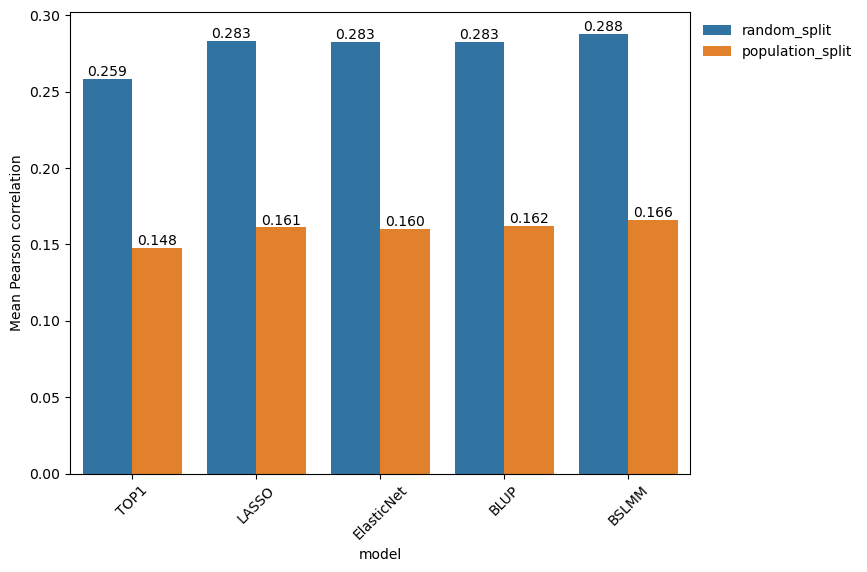

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=results_df, x="model", y="corr", hue="gene_class", ax=ax)
ax.set_ylabel("Mean Pearson correlation")

# Move legend outside of plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="", frameon=False)

# Add values on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", label_type="edge")

# Rotate xticklabels
plt.xticks(rotation=45)

plt.show()

# BLUP scaling analysis

In [19]:
def plot_scaling_results(
    random_split_genes: list[str],
    population_split_genes: list[str],
    ax: plt.Axes,
    preds_dir: str = "preds_scaling",
    subset_pcts: list[int] = [20, 40, 60, 80, 100],
    n_replicates: int = 3,
    model: str = "blup",
):
    # Create results dataframe
    results = defaultdict(list)
    for subset_pct in subset_pcts:
        for replicate in range(n_replicates):
            for split, genes in [
                ("Random-split genes", random_split_genes),
                ("Population-split genes", population_split_genes),
            ]:
                preds_path = os.path.join(
                    preds_dir,
                    f"subset_{subset_pct}",
                    f"replicate_{replicate + 1}",
                    f"{model}.csv",
                )
                results["subset_pct"].append(subset_pct)
                results["replicate"].append(replicate)
                results["split"].append(split)
                results["corr"].append(compute_mean_pearson(counts_df, preds_path, genes))
    df = pd.DataFrame(results)

    # Plot
    sns.lineplot(
        data=df,
        x="subset_pct",
        y="corr",
        hue="split",
        style="split",
        errorbar="sd",
        markers=True,
        dashes=False,
        ax=ax,
    )

    # Add mean +- std text underneath each line
    for split in df["split"].unique():
        for pct in df["subset_pct"].unique():
            subset_df = df[(df["split"] == split) & (df["subset_pct"] == pct)]
            mean = subset_df["corr"].mean()
            std = subset_df["corr"].std()
            text = rf"{mean:.3f} $\pm$" + "\n" + f"{std:.3f}"
            ax.text(pct, mean - std - 0.01, text, ha="center", va="center", fontsize=7)

    ax.set_ylim(0.05)
    ax.set_xlabel("Percentage of training set samples used")
    ax.set_ylabel("Pearson correlation")
    ax.legend(frameon=False, loc="upper left")

/tmp/ipykernel_1573342/1373616837.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_1573342/1373616837.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_1573342/1373616837.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_1573342/1373616837.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_1573342/1373616837.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_1573342/1373616837.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ 

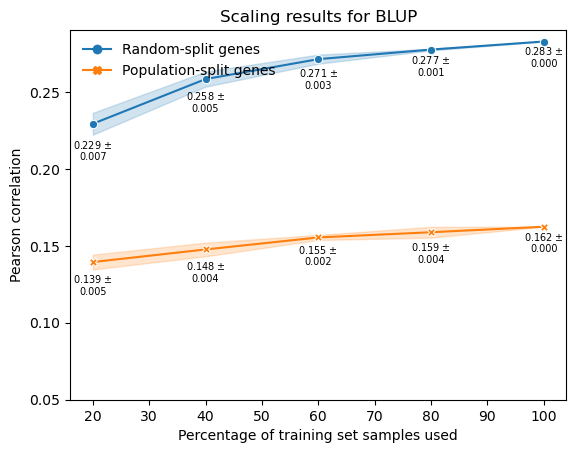

In [20]:
fig, ax = plt.subplots()
plot_scaling_results(random_split_genes, population_split_genes, ax)
ax.set_title("Scaling results for BLUP")
plt.show()

# BLUP rare variant analysis

In [20]:
def plot_scaling_results(
    random_split_genes: list[str],
    population_split_genes: list[str],
    ax: plt.Axes,
    preds_dir: str = "preds_rare_variant_analysis",
    model: str = "blup",
):
    # Get directory names for each MAF
    dirname_per_maf = {}
    for maf_subdir in os.listdir(preds_dir):
        maf = float(maf_subdir.split("_")[1])
        dirname_per_maf[maf] = os.path.join(preds_dir, maf_subdir)
    
    # Create results dataframe
    results = defaultdict(list)
    for maf in sorted(dirname_per_maf):
        for split, genes in [
            ("Random-split genes", random_split_genes),
            ("Population-split genes", population_split_genes),
        ]:
            preds_path = os.path.join(dirname_per_maf[maf], f"{model}.csv")
            results["maf"].append(maf)
            results["split"].append(split)
            results["corr"].append(
                compute_mean_pearson(counts_df, preds_path, genes)
            )
    results_df = pd.DataFrame(results)

    # Plot results
    sns.lineplot(
        data=results_df,
        x="maf",
        y="corr",
        hue="split",
        style="split",
        markers=True,
        dashes=False,
        ax=ax,
    )
    ax.set(
        xlabel="Minimum minor allele frequency",
        ylabel="Mean cross-individual Pearson correlation",
        title="Effect of rare variants on BLUP performance"
    )
    ax.axvline(0.05, ls="--", color="black", alpha=0.2)

/tmp/ipykernel_415849/1373616837.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_415849/1373616837.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_415849/1373616837.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_415849/1373616837.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_415849/1373616837.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds, counts)
/tmp/ipykernel_415849/1373616837.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pear

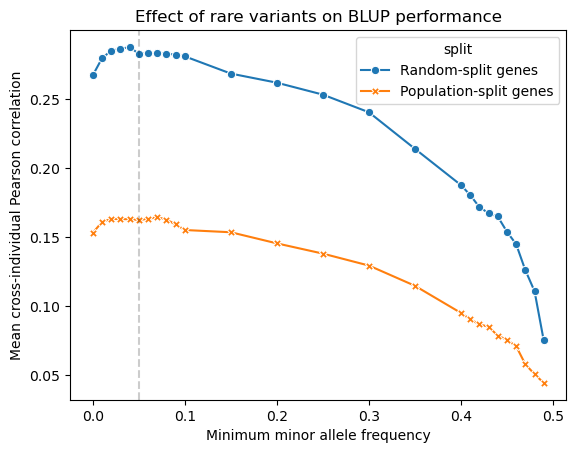

In [21]:
fig, ax = plt.subplots()
plot_scaling_results(random_split_genes, population_split_genes, ax)
plt.show()